In [193]:
#change working directory to the task folder
import os
os.chdir("C:/Users/amydu/OneDrive/Documents/EMBL-EBI_Interview_Task")

In [ ]:
#import necessary libraries
import pandas as pd
import ast
from pyvis.network import Network
from itertools import combinations
import networkx as nx


In [194]:
#import metadata for statistical analysis and visualisation
metadata = pd.read_csv("data/data_retrieval/epmc_metadata.csv")
authors = pd.read_csv("data/data_retrieval/epmc_authors.csv")
metadata_with_pdb = pd.read_csv("data/data_retrieval/metadata_with_pdb.csv")

In [195]:
metadata_with_pdb.head()

,pmid,title,authors,affiliation,journal,journal_nlmid,year,open_access,doi,abstract,Cited_by,pdb_ids
0,40548716,Active site loops of membrane-anchored metallo...,"Carnevale MC, Palacios AR, Hinchliffe P, Delmo...","Laboratorio de Metaloproteínas, Instituto de B...",Antimicrobial agents and chemotherapy,0315061,2025,N,10.1128/aac.01918-24,Antimicrobial resistance is a significant glob...,0,"['9gx8', '9gx9']"
1,40525813,Crystal Structure and Functional Characterizat...,"Choi SY, Kim E, Yoon H, Kim HN, Kim JH, Seok S...",College of Pharmacy and Research Institute of ...,Proteins,8700181,2025,N,10.1002/prot.26854,"The YhcH/YjgK/YiaL (DUF386) family, widely con...",0,['9jrr']
2,40498833,ATP13A1 engages SEC61 to facilitate substrate-...,"Yang X, Li Y, Yang C, Li T, Fang Z, Feng Z, Li...","School of Life Science and Technology, Shangha...",Science advances,101653440,2025,Y,10.1126/sciadv.adt1346,The accurate targeting of proteins to their de...,0,"['9jbr', '9jbz', '9jbm', '9jbx']"
3,40603868,Structure and biochemistry-guided engineering ...,"Edmonds KK, Wilkinson ME, Strebinger D, Chen H...","Howard Hughes Medical Institute, Cambridge, MA...",Nature communications,101528555,2025,Y,10.1038/s41467-025-61321-z,"R2 elements, a class of non-long terminal repe...",0,['9dou']
4,40595028,Polarity protein Par6 facilitates the processi...,"Almagor L, Weis WI.","Department of Structural Biology, Stanford Uni...",Communications biology,101719179,2025,Y,10.1038/s42003-025-08401-4,Polarity along an apical-basal axis is essenti...,0,"['9ejm', '9ejl', '9ejk']"


In [196]:
authors.head()

,pmid,title,author_fullName,author_orcid
0,40548716,Active site loops of membrane-anchored metallo...,Carnevale MC,0000-0002-4156-6815
1,40548716,Active site loops of membrane-anchored metallo...,Palacios AR,0000-0003-2904-7622
2,40548716,Active site loops of membrane-anchored metallo...,Hinchliffe P,0000-0001-8611-4743
3,40548716,Active site loops of membrane-anchored metallo...,Delmonti J,0009-0008-7162-9531
4,40548716,Active site loops of membrane-anchored metallo...,Drusin SI,0000-0001-5350-514X


In [197]:
# look at stats for number of authors per publication
authors_df.groupby('pmid').size().describe()

#mean of 10 authors for each publication
#min of 1 author, max of 213 authors

count    19457.000000
mean        10.808912
std          7.870422
min          1.000000
25%          6.000000
50%          9.000000
75%         13.000000
max        213.000000
dtype: float64

In [198]:
### Find Top Publishing Authors ###

# Drop authors with no ORCID (optional, or use fallback)
authors_df['author_orcid'] = authors_df['author_orcid'].fillna("no_orcid")

# Group by ORCID
grouped = authors_df.groupby('author_orcid')

# Count publications per ORCID
author_counts = grouped.size().reset_index(name='publication_count')

# Get one representative name for each ORCID (first name seen)
author_names = grouped['author_fullName'].first().reset_index()

# Merge counts with names
top_authors = pd.merge(author_counts, author_names, on='author_orcid')

# Sort and select top N
top_authors = top_authors.sort_values('publication_count', ascending=False).head(20)

# Optional: format label for display
top_authors['label'] = top_authors.apply(
    lambda row: f"{row['author_fullName']} ({row['author_orcid']})", axis=1
)

In [199]:
print(top_authors[['label', 'publication_count']])
#Kim E is clearly a lot of differrent authors, so we can filter them out
#filter out all authors without an ORCID for cleaning data

#The highest raw publication count was attributed to “Kim E”, 
# but this author has no ORCID identifier and the count (~117,000) 
# suggests a conflation of multiple individuals with the same name. 
# To avoid misrepresentation, only authors with valid ORCID IDs were used for top-author analysis.

                                    label  publication_count
45769                    Kim E (no_orcid)             116999
25333         Xu HE (0000-0002-6829-8144)                 78
6225        Baker D (0000-0001-7896-6217)                 73
19125        Gao GF (0000-0002-3869-615X)                 67
2166        Knapp S (0000-0001-5995-6494)                 67
4678        Ward AB (0000-0001-7153-3769)                 54
40996    Supuran CT (0000-0003-4262-0323)                 52
24598     Wilson IA (0000-0002-6469-2419)                 49
15130    Rossjohn J (0000-0002-2020-7522)                 46
35834      Nureki O (0000-0003-1813-7008)                 46
40429   McLellan JS (0000-0003-3991-542X)                 46
26407     Davies GJ (0000-0002-7343-776X)                 43
19031    Steyaert J (0000-0002-3825-874X)                 41
9723        Bera AK (0000-0001-9473-2912)                 40
40822         Shi K (0000-0003-4175-3714)                 39
30578          Qi J (000

In [200]:
#remove authors without ORCID
top_authors = top_authors[top_authors['author_orcid'] != "no_orcid"]

In [201]:
print("Top 10 Authors by Publication Count with vaild ORCIDs:")
print(top_authors[['label', 'publication_count']])

Top 10 Authors by Publication Count with vaild ORCIDs:
                                    label  publication_count
25333         Xu HE (0000-0002-6829-8144)                 78
6225        Baker D (0000-0001-7896-6217)                 73
19125        Gao GF (0000-0002-3869-615X)                 67
2166        Knapp S (0000-0001-5995-6494)                 67
4678        Ward AB (0000-0001-7153-3769)                 54
40996    Supuran CT (0000-0003-4262-0323)                 52
24598     Wilson IA (0000-0002-6469-2419)                 49
15130    Rossjohn J (0000-0002-2020-7522)                 46
35834      Nureki O (0000-0003-1813-7008)                 46
40429   McLellan JS (0000-0003-3991-542X)                 46
26407     Davies GJ (0000-0002-7343-776X)                 43
19031    Steyaert J (0000-0002-3825-874X)                 41
9723        Bera AK (0000-0001-9473-2912)                 40
40822         Shi K (0000-0003-4175-3714)                 39
30578          Qi J (0000-0002

In [202]:
orcid_coverage = authors_df['author_orcid'].apply(lambda x: x != "no_orcid").mean()
print(f"ORCID coverage: {orcid_coverage:.2%}")

ORCID coverage: 44.37%


In [203]:
#Approximately 44.4% of authors had ORCID identifiers, enabling disambiguation and reliable counting. 
#The remaining Y% lacked ORCIDs, often leading to ambiguous high-frequency names like “Kim E” being grouped together, 
#which may overinflate their contribution.

In [204]:
from pyvis.network import Network
import pandas as pd
from itertools import combinations
import networkx as nx

### Build Co-Author Network ###
# nodes are authors, edges are co-authorships
# node size based on publication count
# edge weight based on co-authorship frequency

# Step 1: Prepare data
authors_filtered = authors[authors["author_orcid"] != "no_orcid"].copy()
authors_filtered["author_id"] = authors_filtered["author_orcid"]

# Step 2: Count publications per author
author_counts = authors_filtered["author_id"].value_counts()
top_authors = author_counts.head(200).index.tolist()  # Adjust N as needed

# Step 3: Build graph
G = nx.Graph()
grouped = authors_filtered.groupby("pmid")

for _, group in grouped:
    coauthors = list(set(group["author_id"]))
    for a1, a2 in combinations(coauthors, 2):
        if G.has_edge(a1, a2):
            G[a1][a2]["weight"] += 1
        else:
            G.add_edge(a1, a2, weight=1)

# Step 4: Filter subgraph to top authors
G_sub = G.subgraph(top_authors).copy()

# Optional: enrich with names for display
author_id_to_name = dict(zip(authors_filtered["author_id"], authors_filtered["author_fullName"]))

# Step 5: Visualize using Pyvis
net = Network(height="600px", width="1000px", notebook=True)
net.from_nx(G_sub)

for node in net.nodes:
    author_id = node["id"]
    name = author_id_to_name.get(author_id, "Unknown")
    pub_count = int(author_counts.get(author_id, 0))
    node["title"] = f"{name}<br>ORCID: {author_id}<br>Publications: {pub_count}"
    node["label"] = name
    node["value"] = pub_count
    node["font"] = {"size": 20}

net.show("author_collab_network.html")
#download html and view in browser

author_collab_network.html


In [206]:
# Step 1: Extract edge weights into a DataFrame
top_edges = [
    (u, v, data["weight"])
    for u, v, data in G.edges(data=True)
    if "weight" in data
]

collab_df = pd.DataFrame(top_edges, columns=["Author1", "Author2", "Publications"])

# Step 4: Remove rows with missing names
collab_df = collab_df.dropna(subset=["Author1", "Author2"])


# Step 2: Sort by number of shared publications
collab_df = collab_df.sort_values(by="Publications", ascending=False)

# Step 3: Optional – map ORCID to names if available
collab_df["Author1_Name"] = collab_df["Author1"].map(author_id_to_name)
collab_df["Author2_Name"] = collab_df["Author2"].map(author_id_to_name)

# Step 4: View or save
top_n = 15
print(collab_df[["Author1_Name", "Author2_Name", "Publications"]].head(top_n))


       Author1_Name Author2_Name  Publications
65798    Supuran CT     Angeli A            36
88535        Gao GF         Qi J            33
86758        Yang D      Wang MW            32
44887       Baker D      Bera AK            32
47206    Steyaert J     Pardon E            32
85160         Xu HE         He X            31
85075       Jiang Y        Xu HE            28
73544         Shi K     Aihara H            24
52340       Knapp S   Chaikuad A            22
85307       Zhang Y        Mao C            22
70856     Shihoya W     Nureki O            20
85165         Xu HE       Yang D            20
113406    Garcia KC      Jude KM            20
68212       Carta F     Angeli A            20
75482         Zhu X    Wilson IA            20


In [207]:
# calculate number of publications per year
articles_per_year = epmc_df.groupby('year').size()

# calculate growth rate of publications per year
growth_rate = articles_per_year.pct_change().fillna(0) * 100

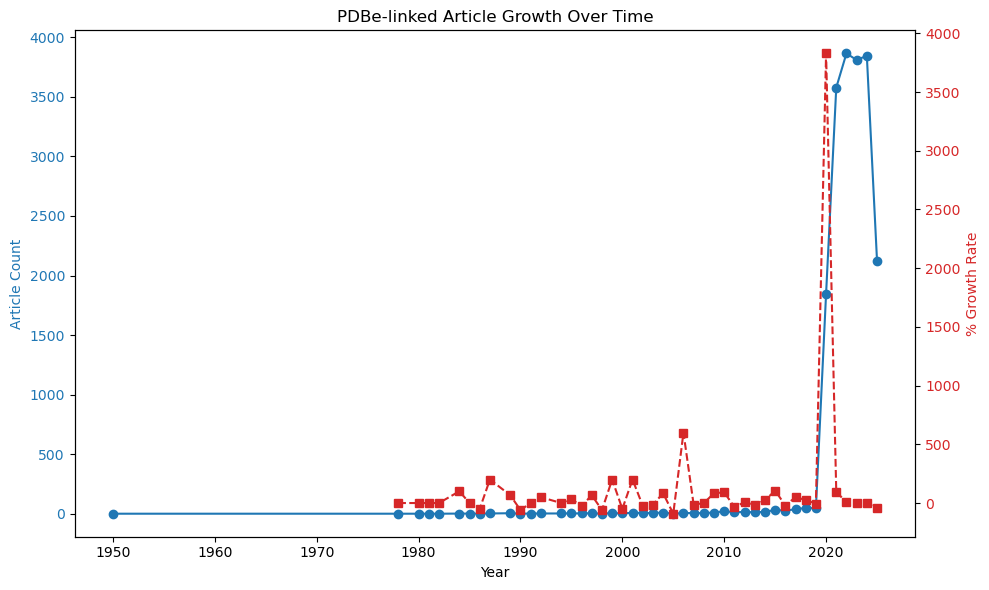

In [208]:
import matplotlib.pyplot as plt

# Calculate articles per year
articles_per_year = epmc_df.groupby('year').size()
growth_rate = articles_per_year.pct_change() * 100  # % growth

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary Y-axis: Number of articles
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Article Count', color=color)
ax1.plot(articles_per_year.index, articles_per_year.values, marker='o', color=color, label='Articles')
ax1.tick_params(axis='y', labelcolor=color)

# Secondary Y-axis: Growth rate
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('% Growth Rate', color=color)
ax2.plot(growth_rate.index, growth_rate.values, marker='s', linestyle='--', color=color, label='Growth Rate')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('PDBe-linked Article Growth Over Time')
fig.tight_layout()
plt.show()


In [209]:
# Number of Unique Authors with ORCID 
authors_df['author_orcid'].nunique()

45770

In [210]:
metadata['affiliation'].value_counts()

affiliation
Department of Biochemistry, University of Washington, Seattle, WA, USA.                                        40
MRC Laboratory of Molecular Biology, Cambridge, UK.                                                            29
Department of Structural Biology, Van Andel Institute, Grand Rapids, MI, USA.                                  20
Department of Molecular and Cellular Physiology, Stanford University School of Medicine, Stanford, CA, USA.    20
Department of Biochemistry, University of Zurich, Zurich, Switzerland.                                         19
                                                                                                               ..
Department of Biosciences, Durham University, Stockton Road, Durham DH1 3LE, UK.                                1
Lymphocyte Nuclear Biology, NIAMS, NIH, Bethesda, MD, USA. jianliang.xu@nih.gov.                                1
Department of Medicine, School of Medicine, University of California, San Di

In [212]:
metadata_with_pdb['pdb_ids'].apply(len).describe()

count    19457.000000
mean        24.295729
std         52.810080
min          2.000000
25%          8.000000
50%         16.000000
75%         24.000000
max       3728.000000
Name: pdb_ids, dtype: float64

In [213]:
metadata['journal'].value_counts().head(10)

journal
Nature communications                                                              2440
Proceedings of the National Academy of Sciences of the United States of America     897
Journal of medicinal chemistry                                                      862
The Journal of biological chemistry                                                 749
Nature                                                                              623
Nucleic acids research                                                              568
Science advances                                                                    460
Nature structural & molecular biology                                               434
Structure (London, England : 1993)                                                  424
Science (New York, N.Y.)                                                            371
Name: count, dtype: int64